In [1]:
from helita.sim import bifrost as br

In [2]:
dd = br.BifrostData('cb10f', snap = 430, fdir = '/net/opal/Volumes/Amnesia/mpi3drun/Granflux', verbose = False)

In [3]:
var1 = dd.get_var('r', snap = 430, iiy = 200, iiz = [5, 7])

In [4]:
time = dd.params['t']

In [5]:
dd.params.keys()

dict_keys(['mx', 'my', 'mz', 'mb', 'nstep', 'nstepstart', 'debug', 'periodic_x', 'periodic_y', 'periodic_z', 'ndim', 'u_l', 'u_t', 'u_r', 'u_p', 'u_u', 'u_kr', 'u_ee', 'u_e', 'u_te', 'u_tg', 'u_b', 'meshfile', 'dx', 'dy', 'dz', 'cdt', 'dt', 't', 'timestepdebug', 'nu1', 'nu2', 'nu3', 'nu_r_xy', 'nu_r_xy_k', 'nu_r', 'nu_r_min', 'nu_r_k', 'nu_ee_xy', 'nu_ee', 'grav', 'eta3', 'ca_max', 'mhddebug', 'do_mhd', 'mhdclean', 'one_file', 'snapname', 'isnap', 'large_memory', 'nsnap', 'nscr', 'aux', 'dtsnap', 'newaux', 'dtscr', 'tsnap', 'tscr', 'boundarychk', 'max_r', 'smooth_r', 'qmax', 'noneq', 'do_hion', 'gamma', 'tabinputfile', 'do_rad', 'dtrad', 'quadrature', 'zrefine', 'maxiter', 'taustream', 'accuracy', 'strictint', 'linear', 'monotonic', 'minbin', 'maxbin', 'dualsweep', 'teff', 'timing', 'spitzer', 'debug_spitzer', 'info_spitzer', 'spitzer_amp', 'theta_mg', 'dtgerr', 'ntest_mg', 'tgb0', 'tgb1', 'tau_tg', 'fix_grad_tg', 'niter_mg', 'bmin', 'do_genrad', 'genradfile', 'debug_genrad', 'incrad_d

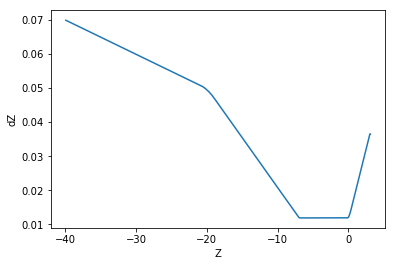

In [6]:
from helita.sim import bifrost as br
import matplotlib.pyplot as plt
import numpy as np

rootname='l2d90x40r_it' #this is for the 2D case
fdir='/net/opal/Volumes/Amnesia/mpi3drun/2Druns/genohm/rain/l2d90x40r'
dd=br.BifrostData(rootname,fdir=fdir, verbose = False) #this loads the structure
var=dd.get_var('r',305) #this reads the density (r) for the instant 305 

# gets the z coordinates of data points and makes an empty array of the same length for values of dz
zarr = dd.z
length = zarr.shape[0]
dzarr = np.empty([length])

# iterates through zarr and sets each entry in dzarr as the difference between the next and current values of z
# for the final value of dzarr, sets it to be the same as the previous value of dzarr
for i, val in enumerate(zarr):
    if i < length - 1 :
        dzarr[i] = zarr[i + 1] - val
        i = i + 1
        
    else :
        dzarr[i] = dzarr[i - 1]

# plots z vs dz and labels the axes
plt.plot(zarr, dzarr)
plt.xlabel('Z')
plt.ylabel('dZ')
plt.show()



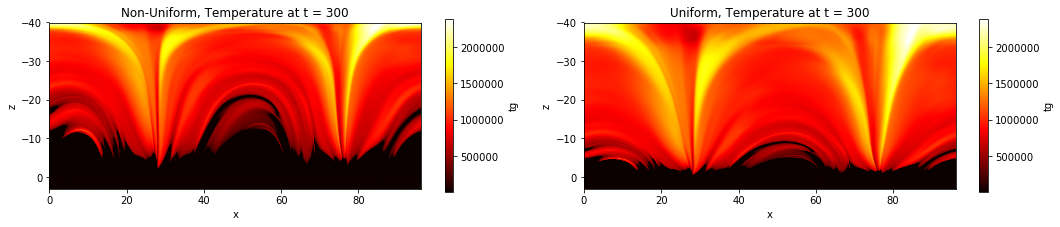

In [7]:
import scipy.interpolate as sp
# bifrost already imported and dd initialized after previous example

temp = dd.get_var('tg', 300)

zarr = dd.z
xarr = dd.x

# at instant 305 -  x is uniform, y is kept constant, and z is non uniform
    
# converts the 3d array with width of 1 to 2d array (and transposes because otherwise image is sidewise)
temp2d = np.transpose(temp[:,0])

f = sp.interp2d(xarr, zarr, temp2d)

# makes a new uniform z, x is already uniform
zlength = zarr.shape[0]
zstart = zarr[0]
zend = zarr[zlength - 1]
newz = np.linspace(zstart, zend, zlength)

# makes the interpolated data with the previously created interpolation function acting on the new uniform axes
uniform_a = f(xarr, newz)
    
fig = plt.figure(figsize = (15, 3))
    
# optional plotting of the non uniform data to show the difference
ax0 = fig.add_subplot(1, 2, 1)
im0 = ax0.imshow(temp2d, cmap = 'hot', extent = (xarr[0], xarr[xarr.shape[0] - 1], zend, zstart), aspect = 'equal')
ax0.set_title('Non-Uniform, Temperature at t = 300')
ax0.set_xlabel('x')
ax0.set_ylabel('z')
c0 = fig.colorbar(im0, ax = ax0)
c0.set_label('tg')
    
ax1 = fig.add_subplot(1, 2, 2)
im1 = ax1.imshow(uniform_a, cmap = 'hot', extent = (xarr[0], xarr[xarr.shape[0] - 1], zend, zstart), aspect = 'equal')
ax1.set_title('Uniform, Temperature at t = 300')
ax1.set_xlabel('x')
ax1.set_ylabel('z')
c1 = fig.colorbar(im1, ax = ax1)
c1.set_label('tg')
plt.tight_layout()
plt.show()


In [8]:
from helita.sim import bifrost_fft as brft

In [9]:
dd = brft.FFTData(file_root = 'cb10f', fdir = '/net/opal/Volumes/Amnesia/mpi3drun/Granflux')

In [10]:
transformed = dd.get_fft('alf', snap = [430, 431, 432], iix = 5, iiy = 20)

In [11]:
transformed.keys()

dict_keys(['freq', 'ftCube'])

In [12]:
dd.run_gpu() # to use GPU
dd.run_gpu(False) # to stop use of GPU

In [13]:
usingBlocks = dd.get_fft('bx', snap = [400, 401, 402], numBlocks = 5)

In [14]:
usingThreads = dd.get_fft('bx', snap = [400, 401, 402], numThreads = 10)

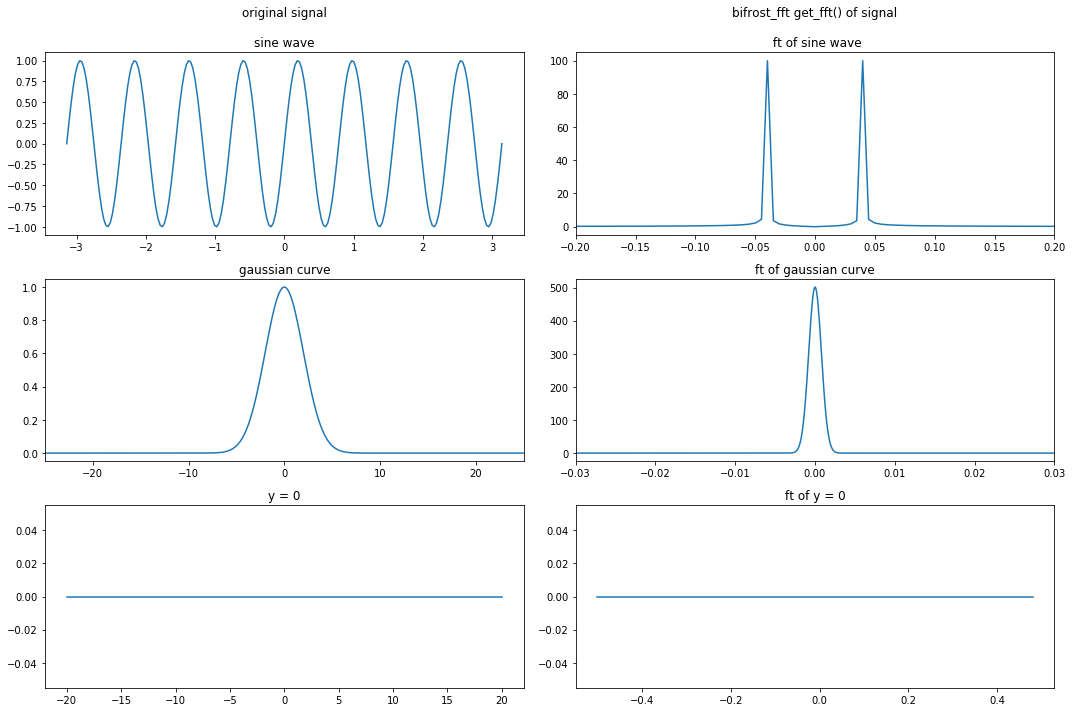

In [15]:
import numpy as np
import helita.sim.cstagger
from helita.sim.bifrost import BifrostData, Rhoeetab, read_idl_ascii
from helita.sim.bifrost_fft import FFTData
import matplotlib.pyplot as plt

# note: this calls bifrost_fft from user, not /sanhome

dd = FFTData(file_root='cb10f',
             fdir='/net/opal/Volumes/Amnesia/mpi3drun/Granflux')

# test 1: ft of y = sin(8x)
x = np.linspace(-np.pi, np.pi, 201)
dd.preTransform = np.sin(8 * x)
dd.freq = np.fft.fftshift(np.fft.fftfreq(np.size(x)))
dd.run_gpu(False)
# preTransform is already set
tester = dd.get_fft('not a real var', snap='test')
fig = plt.figure(figsize=(15,10))

numC = 3
numR = 2

# plotting original sin signal
ax0 = fig.add_subplot(numC, numR, 1)
ax0.plot(x, dd.preTransform)
ax0.set_title('original signal' + '\n\nsine wave')

# plotting transformation sin signal
ax1 = fig.add_subplot(numC, numR, 2)
ax1.plot(tester['freq'], tester['ftCube'])
ax1.set_title('bifrost_fft get_fft() of signal' + '\n\n ft of sine wave')
ax1.set_xlim(-.2, .2)

# test 2: ft of gaussian curve
n = 30000  # Number of data points
dx = .01  # Sampling period (in meters)
x = dx*np.linspace(-n/2, n/2, n)  # x coordinates

stanD = 2  # standard deviation
dd.preTransform = np.exp(-0.5 * (x/stanD)**2)

# plotting original gaussian signal
ax2 = fig.add_subplot(numC, numR, 3)
ax2.plot(x, dd.preTransform)
ax2.set_xlim(-25, 25)
ax2.set_title('gaussian curve')

# plotting transformation of gaussian signal
dd.freq = np.fft.fftshift(np.fft.fftfreq(np.size(x)))
ft = dd.get_fft('not a real var', snap='test')  # preTransform is already set
ax3 = fig.add_subplot(numC, numR, 4)
ax3.plot(ft['freq'], ft['ftCube'])
ax3.set_xlim(-.03, .03)
ax3.set_title('ft of gaussian curve')

# test 3: ft of y = 0
# plotting original horizontal line
x = np.linspace(-20, 20, 50)
dd.preTransform = [0] * 50
ax4 = fig.add_subplot(numC, numR, 5)
ax4.plot(x, dd.preTransform)
ax4.set_title('y = 0')

# plotting transformed signal
dd.freq = np.fft.fftshift(np.fft.fftfreq(np.size(x)))
ft = dd.get_fft('not a real var', snap='test')  # preTransform is already set
ax5 = fig.add_subplot(numC, numR, 6)
ax5.plot(ft['freq'], ft['ftCube'])
ax5.set_title('ft of y = 0')

plt.tight_layout()
plt.show()

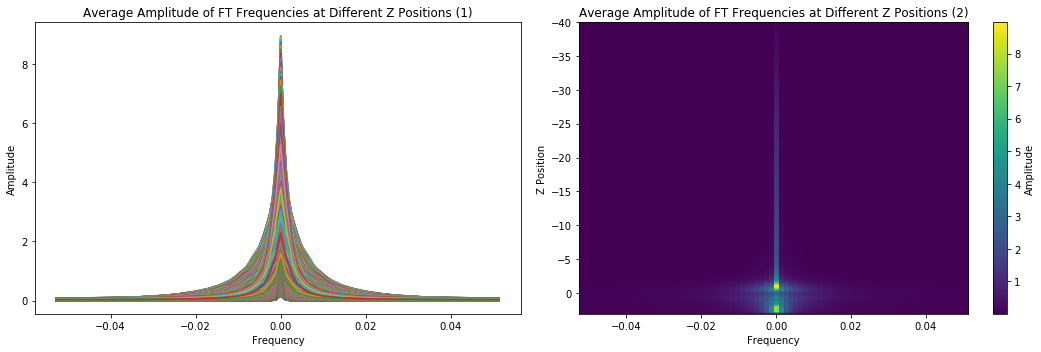

In [18]:
import numpy as np
import helita.sim.cstagger
from helita.sim.bifrost import BifrostData, Rhoeetab, read_idl_ascii
from helita.sim.bifrost_fft import FFTData
import matplotlib.pyplot as plt

snaps = np.arange(280, 360)
v = 'bx'

dd = FFTData(file_root='l2d90x40r_it',
             fdir='/net/opal/Volumes/Amnesia/mpi3drun/2Druns/genohm/rain/l2d90x40r/')

# getting ft
transformed = dd.get_fft(v, snaps)
ft = transformed['ftCube']
freq = transformed['freq']
zaxis = dd.z

# making empty array to later contain the avergaes for each z position
zstack = np.empty([np.size(freq), np.shape(ft)[1]])
# filling ztack with average ft for each (x,y) in each z level
for k in range(0, np.shape(ft)[1]):
    avg = np.average(ft[:, k, :], axis=(0))
    zstack[:, k] = avg

# preparing plots
fig = plt.figure(figsize = (15, 5))
numC = 1
numR = 2

# ploting freq vs amp with multiple lines (1 for each z position)
ax0 = fig.add_subplot(numC, numR, 1)
ax0.plot(freq, zstack)
ax0.set_xlabel('Frequency')
ax0.set_ylabel('Amplitude')
ax0.set_title(
    'Average Amplitude of FT Frequencies at Different Z Positions (1)')
ax0.set_aspect('auto')

# plotting amp at different freq & z with image
ax1 = fig.add_subplot(numC, numR, 2)
im1 = ax1.imshow(zstack.transpose(), extent=[freq[0], freq[-1], zaxis[-1], zaxis[0]])
ax1.set_xlabel('Frequency')
ax1.set_ylabel('Z Position')
ax1.set_title(
    'Average Amplitude of FT Frequencies at Different Z Positions (2)')
ax1.set_aspect('auto')
c1 = fig.colorbar(im1, ax = ax1)
c1.set_label('Amplitude')
plt.tight_layout()
plt.show()